### Runs Documentation
##### Perhaps better done with MLFlow?

1. Original Kernel. No changes. 10 epochs: FID_public:  54.10607425172839 distance_public:  1 multiplied_public:  54.10607425172785

2.  20 epochs: FID_public:  52.54344008314399 distance_public:  1 multiplied_public:  52.543440083143466
3.  Back to 10 epochs. beta=0.1: FID_public:  49.69019449377248 distance_public:  1 multiplied_public:  49.69019449377198
4.  Back to 10 epochs. beta=0.2: FID_public:  62.2119199335242 distance_public:  1 multiplied_public:  62.21191993352358
5.  Back to 10 epochs. beta=0.3: FID_public:  75.88560313464586 distance_public:  1 multiplied_public:  75.88560313464511
6.  Back to 10 epochs. beta=0.05: FID_public:  75.5801331680297 distance_public:  1 multiplied_public:  75.58013316802895
7.  Back to 10 epochs. beta=0.09: FID_public:  53.59719089964847 distance_public:  1 multiplied_public:  53.597190899647934
8.  Back to 10 epochs. beta=0.095: FID_public:  48.273380641802646 distance_public:  1 multiplied_public:  48.27338064180216
9.  Back to 10 epochs. beta=0.091: FID_public:  47.28831054420954 distance_public:  1 multiplied_public:  47.28831054420907




# Dog Autoencoder
## DISCLAIMER: This may not be a valid competition submission
In this kernel, we learn about autoencoders. By understanding autoencoders, we will better understand GANs (Generative Adversarial Networks) and VAEs (Variational Autoencoders). We will also learn how to use an autoencoder to generate images of dogs.
![image](http://playagricola.com/Kaggle/ae7119.jpg)
  
Kaggle's "Generative Dog Images" competition asks us to generate dog images using **generative methods**. It is unclear whether we must use GANs. If we must use GANs, then this kernel's output is **not** a valid competition submission.
# Load Data and Augment
We will randomly crop the original 20,000 images and make 500,000 new training images.

In [1]:
!ls ../input

all-dogs    cropped_images   __MACOSX
Annotation  for_metric_calc  processed_images


In [2]:
# GG Changes
# GG ComputeLB = True

import os, gc, zipfile
import numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# GG: if ComputeLB: PATH = '../input/for_metric_calc/images/'
# GG: else: PATH = '../input/all-dogs/all-dogs/'
# GG New
PATH = '../input/all-dogs/all-dogs/'
IMAGES = os.listdir(PATH)
print('There are',len(IMAGES),'images. Here are 5 example filesnames:')
print(IMAGES[:5])

There are 20579 images. Here are 5 example filesnames:
['n02087046_1004.jpg', 'n02091467_6670.jpg', 'n02089867_1546.jpg', 'n02106550_8776.jpg', 'n02101556_2725.jpg']


In [3]:
# Setup to use GPU 0
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [4]:
# Constants
NUM_CROPPED_IMAGES = 500000
CROPPED_IMAGES_DIR = '../input/cropped_images/'

In [5]:
MAKE_CROPPED_IMAGES = False

if MAKE_CROPPED_IMAGES:
    os.mkdir(CROPPED_IMAGES_DIR)
    os.mkdir(CROPPED_IMAGES_DIR + 'images/')

    # CREATE RANDOMLY CROPPED IMAGES
    for i in range(NUM_CROPPED_IMAGES):
        img = Image.open(PATH + IMAGES[i%len(IMAGES)])
        img = img.resize(( 100,int(img.size[1]/(img.size[0]/100) )), Image.ANTIALIAS)
        w = img.size[0]; h = img.size[1]; a=0; b=0
        if w>64: a = np.random.randint(0,w-64)
        if h>64: b = np.random.randint(0,h-64)
        img = img.crop((a, b, 64+a, 64+b))
        img.save(CROPPED_IMAGES_DIR+str(i)+'.png','PNG')
        if i%100000==0: print('created',i,'cropped images')
    print('created 500000 cropped images')

# Build Autoencoder
This code is inspired by Keras' tutorial [here][1]

[1]: https://blog.keras.io/building-autoencoders-in-keras.html

In [6]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

BATCH_SIZE = 256; EPOCHS = 10
train_datagen = ImageDataGenerator(rescale=1./255)
train_batches = train_datagen.flow_from_directory(CROPPED_IMAGES_DIR,
        target_size=(64,64), shuffle=True, class_mode='input', batch_size=BATCH_SIZE)

Using TensorFlow backend.


Found 500000 images belonging to 1 classes.


In [7]:
# ENCODER
input_img = Input(shape=(64, 64, 3))  
x = Conv2D(48, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# LATENT SPACE
latentSize = (8,8,32)

# DECODER
direct_input = Input(shape=latentSize)
x = Conv2D(192, (1, 1), activation='relu', padding='same')(direct_input)
x = UpSampling2D((2, 2))(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# COMPILE
encoder = Model(input_img, encoded)
decoder = Model(direct_input, decoded)
autoencoder = Model(input_img, decoder(encoded))

autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


# Train Autoencoder

In [8]:
history = autoencoder.fit_generator(train_batches,
        steps_per_epoch = train_batches.samples // BATCH_SIZE,
        epochs = EPOCHS, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 275s - loss: 0.5531
Epoch 2/10
 - 269s - loss: 0.5451
Epoch 3/10
 - 275s - loss: 0.5438
Epoch 4/10
 - 276s - loss: 0.5430
Epoch 5/10
 - 277s - loss: 0.5425
Epoch 6/10
 - 273s - loss: 0.5421
Epoch 7/10
 - 274s - loss: 0.5418
Epoch 8/10
 - 277s - loss: 0.5416
Epoch 9/10
 - 278s - loss: 0.5415
Epoch 10/10
 - 274s - loss: 0.5413


# View Reconstruction
Our encoder works by mapping images from 12288 dimensional space (64 x 64 x 3) into 2048 dimensional space (latent image). This is a 6x compression rate. Our decoder works by mapping our latent image back into 12288 dimensional space. Below are examples. (Note that a decoder is like a GAN generator).

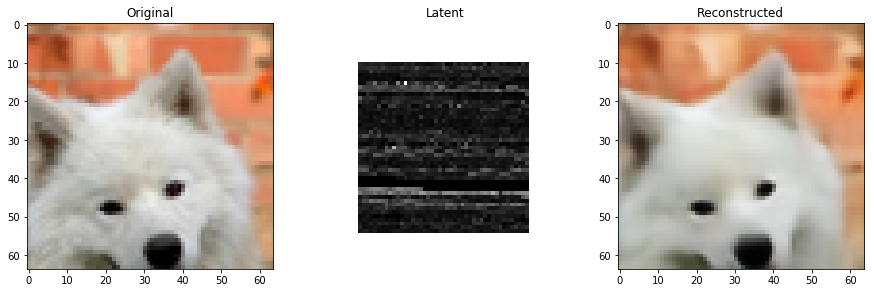

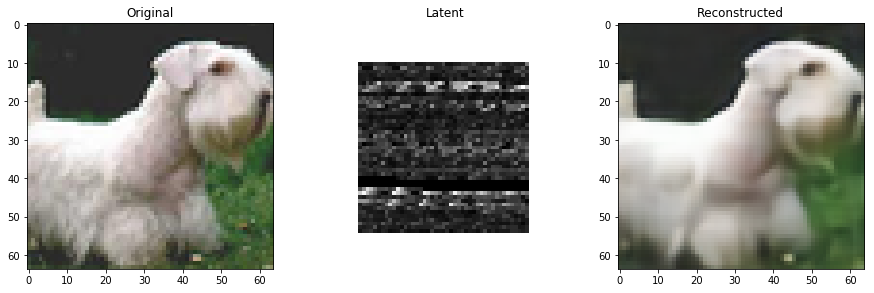

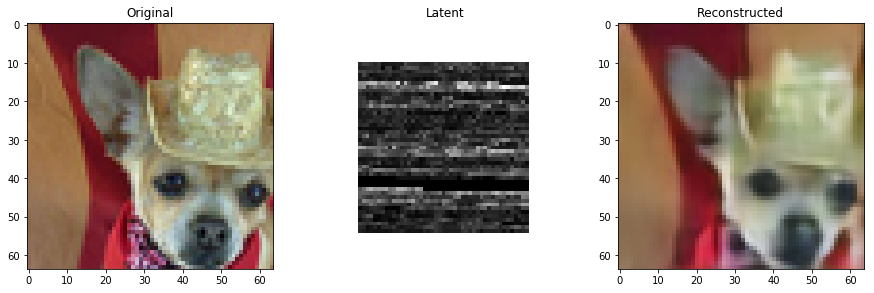

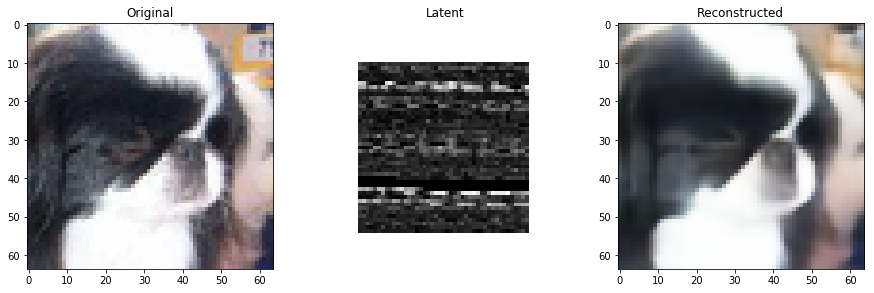

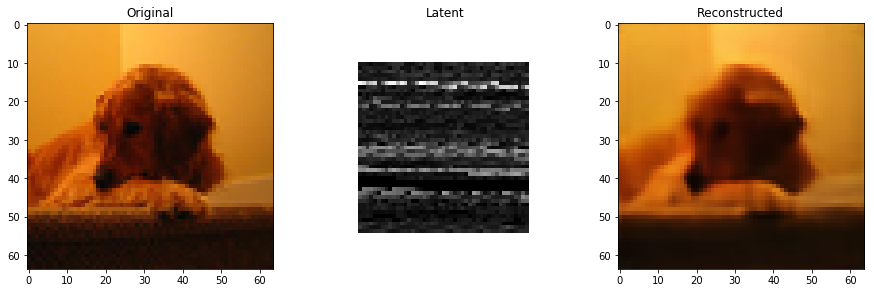

In [9]:
images = next(iter(train_batches))[0]
for i in range(5):

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    
    # ORIGINAL IMAGE
    orig = images[i,:,:,:].reshape((-1,64,64,3))
    img = Image.fromarray( (255*orig).astype('uint8').reshape((64,64,3)))
    plt.title('Original')
    plt.imshow(img)

    # LATENT IMAGE
    latent_img = encoder.predict(orig)
    mx = np.max( latent_img[0] )
    mn = np.min( latent_img[0] )
    latent_flat = ((latent_img[0] - mn) * 255/(mx - mn)).flatten(order='F')
    img = Image.fromarray( latent_flat[:2025].astype('uint8').reshape((45,45)), mode='L') 
    plt.subplot(1,3,2)
    plt.title('Latent')
    plt.xlim((-10,55))
    plt.ylim((-10,55))
    plt.axis('off')
    plt.imshow(img)

    # RECONSTRUCTED IMAGE
    decoded_imgs = decoder.predict(latent_img[0].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.subplot(1,3,3)
    plt.title('Reconstructed')
    plt.imshow(img)
    
    plt.show()

# Latent Space and Dog Generation
We choose the size of latent space. In our autoencoder, we chose for latent space to be 2048 dimensional (6x compression). If we map all 20,000 images into latent space, they would cluster inside a 2048 dimensional hyperellipsoid. That ellipsoid would represent dog images. (Cat images would form a different ellipsoid). Below I have plotted 256 of our dog images in latent space as blue dots and drew their ellipsoid. (Note that latent space is being projected onto 2D for display in this kernel). (Note because of ReLU, you may see clipping).

If we would like to generate a new dog image, we can chose a new random point (different from existing training image dots) inside this ellipsoid and then decode it. For example, we could choose the 9 red points below and then convert them into dog images.

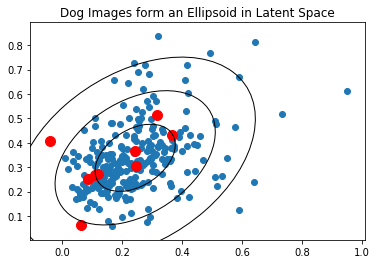

In [10]:
from matplotlib.patches import Ellipse

# PROJECT LATENT INTO 2D, AVOID DEAD RELU
latent_img = encoder.predict(images)
latent_img2 = latent_img.reshape((-1,latentSize[0]*latentSize[1]*latentSize[2]))
d = 0; s = 0
while s<0.1:
    x = latent_img2[:,d]
    s = np.std(x); d += 1
s = 0
while s<0.1:
    y = latent_img2[:,d]
    s = np.std(y); d += 1

# CALCULATE ELLIPSOID FROM 256 IMAGES
cov = np.cov(x, y)
lambda_, v = np.linalg.eig(cov)
lambda_ = np.sqrt(lambda_)
for j in [1,2,3]:
    ell = Ellipse(xy=(np.mean(x), np.mean(y)), width=lambda_[0]*j*2, 
            height=lambda_[1]*j*2, angle=np.rad2deg(np.arccos(v[0, 0])))
    ell.set_facecolor('None')
    ell.set_edgecolor('black')
    plt.gca().add_artist(ell)
    
# PLOT 256 IMAGES AS DOTS IN LATENT SPACE
plt.scatter(x,y)
d = np.random.multivariate_normal([np.mean(x),np.mean(y)],cov,9)
plt.scatter(d[:,0],d[:,1],color='red',s=100)
plt.title('Dog Images form an Ellipsoid in Latent Space')
plt.show()

In [11]:
# CREATE 10000 CROPPED IMAGES
x = np.random.choice(np.arange(20000),10000)
images = np.zeros((10000,64,64,3))
for i in range(len(x)):
    img = Image.open(PATH + IMAGES[x[i]])
    img = img.resize((100,int(img.size[1]/(img.size[0]/100))), Image.ANTIALIAS)
    img = img.crop((18, 0, 82, 64))
    images[i,:,:,:] = np.asarray(img).astype('float32') / 255.
    #if i%1000==0: print(i)
        
# CALCULATE ELLIPSOID FROM 10000 IMAGES        
encoded_imgs = encoder.predict(images)
sz = latentSize[0] * latentSize[1] * latentSize[2]
encoded_imgs = encoded_imgs.reshape((-1,sz))
mm = np.mean(encoded_imgs,axis=0)
ss = np.cov(encoded_imgs,rowvar=False)

# GENERATE 9 RANDOM DOG IMAGES
generated = np.random.multivariate_normal(mm,ss,9)
generated = generated.reshape((-1,latentSize[0],latentSize[1],latentSize[2]))

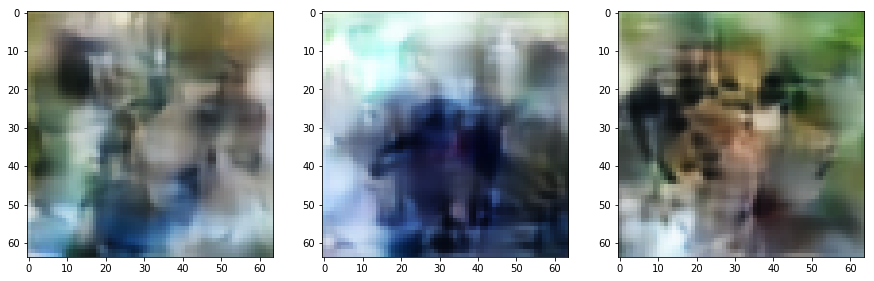

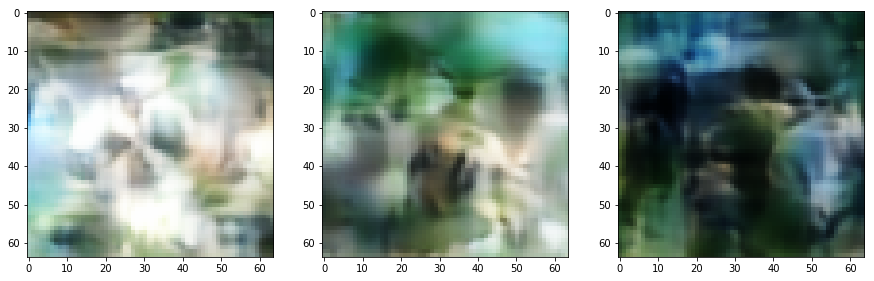

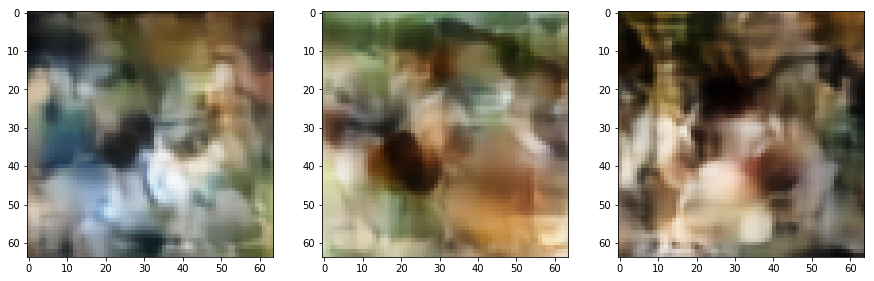

In [12]:
# PLOT 9 RANDOM DOG IMAGES
for k in range(3):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    decoded_imgs = decoder.predict(generated[k*3].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,3,2)
    decoded_imgs = decoder.predict(generated[k*3+1].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,3,3)
    decoded_imgs = decoder.predict(generated[k*3+2].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.show()

# How is LB scored?
What is the FID (Fréchet Inception Distance) metric? Now that we understand latent space, the FID metric is easy to understand. After we train our autoencoder, we can compute the latent hyper-ellipsoid of our dog training data. Then if someone generates dog images, we could feed them into our autoencoder and calculate the latent hyper-ellipsoid of their generated dog images. Then FID is basically the distance between the two latent hyper-ellipsoids squared.

Let `e1` be the training dog ellipsoid and `e2` be the generated dog ellipsoid. Let `x0, x1, ..., x2047` be the 2048 features of latent space. Each vector `x_k` from training dataset `e1` has approx 20000 values, and `e2` has 10000. Then the distance between the ellipsoids is approx the sum of the difference of means (ellipse centers) and sum of the difference of standard deviations (ellipse widths) of each 2048 `x_k`, i.e. `(mean(x_k)_e1 - mean(x_k)_e2)` plus `(std(x_k)_e1 - std(x_k)_e2)` for each of the 2048 `k` values. Finally `FID = this sum^2`.

In the image below, `FID approx = ||c2-c1||^2 + (h2-h1)^2 + (w2-w1)^2`. (Note this is exact when features are uncorrelated). MiFID adds a multiplier penalty if your dog images are too similar to the training data. `MiFID = FID * penalty`.

![image](http://playagricola.com/Kaggle/ellipsesb7119.jpg)

# Generating Better Dog Images
The generated dog images above are not very recognizable. Instead of choosing completely random points in latent space, we can choose points near existing training images. Let's try that.

In [13]:
# DISTANCE TO MOVE AWAY FROM EXISTING TRAIN IMAGES
beta = 0.5
# GENERATE 9 RANDOM DOG IMAGES
generated = np.random.multivariate_normal(mm,ss,9)
images = next(iter(train_batches))[0]
generated = beta*generated*beta + (1-beta)*encoded_imgs[:9]

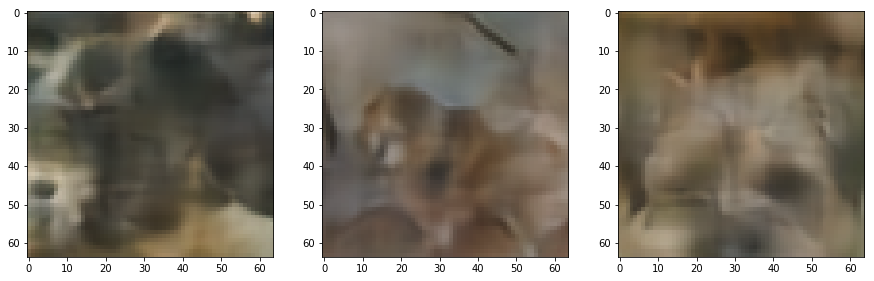

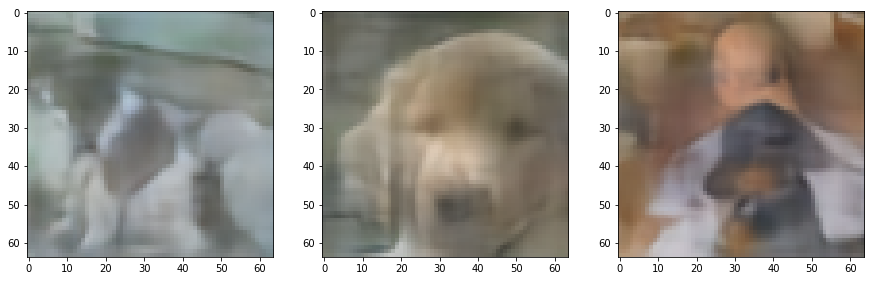

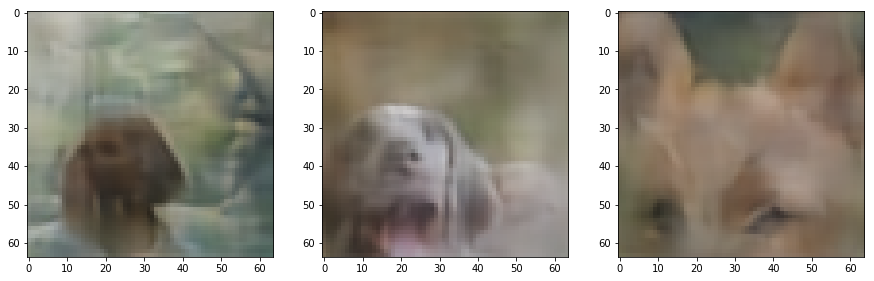

In [14]:
for k in range(3):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    decoded_imgs = decoder.predict(generated[k*3].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,3,2)
    decoded_imgs = decoder.predict(generated[k*3+1].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,3,3)
    decoded_imgs = decoder.predict(generated[k*3+2].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.show()

In [21]:
######### Jigja beta
beta = 0.091
######### 
# GENERATE 10000 RANDOM DOG IMAGES FOR KAGGLE
generated = np.random.multivariate_normal(mm,ss,10000)
encoded_imgs = beta*generated + (1-beta)*encoded_imgs
decoded_imgs = decoder.predict(encoded_imgs.reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
decoded_imgs.shape

(10000, 64, 64, 3)

# Submit to Kaggle

In [22]:
# SAVE TO ZIP FILE NAMED IMAGES.ZIP
z = zipfile.PyZipFile('../output/images.zip', mode='w')
for k in range(10000):
    img = Image.fromarray( (255*decoded_imgs[k]).astype('uint8').reshape((64,64,3)))   
    f = str(k)+'.png'
    img.save(f,'PNG'); z.write(f); os.remove(f)
    #if k % 1000==0: print(k)
z.close()

# Calculate LB Score
If you wish to compute LB, you must add the LB metric dataset [here][1] to this kernel and change the boolean variable in the first cell block.

[1]: https://www.kaggle.com/wendykan/dog-face-generation-competition-kid-metric-input

In [23]:
from __future__ import absolute_import, division, print_function
import numpy as np
import os
import gzip, pickle
import tensorflow as tf
from scipy import linalg
import pathlib
import urllib
import warnings
from tqdm import tqdm
from PIL import Image

class KernelEvalException(Exception):
    pass

model_params = {
    'Inception': {
        'name': 'Inception', 
        'imsize': 64,
        'output_layer': 'Pretrained_Net/pool_3:0', 
        'input_layer': 'Pretrained_Net/ExpandDims:0',
        'output_shape': 2048,
        'cosine_distance_eps': 0.1
        }
}

def create_model_graph(pth):
    """Creates a graph from saved GraphDef file."""
    # Creates graph from saved graph_def.pb.
    with tf.gfile.FastGFile( pth, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString( f.read())
        _ = tf.import_graph_def( graph_def, name='Pretrained_Net')

def _get_model_layer(sess, model_name):
    # layername = 'Pretrained_Net/final_layer/Mean:0'
    layername = model_params[model_name]['output_layer']
    layer = sess.graph.get_tensor_by_name(layername)
    ops = layer.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            if shape._dims != []:
              shape = [s.value for s in shape]
              new_shape = []
              for j, s in enumerate(shape):
                if s == 1 and j == 0:
                  new_shape.append(None)
                else:
                  new_shape.append(s)
              o.__dict__['_shape_val'] = tf.TensorShape(new_shape)
    return layer

def get_activations(images, sess, model_name, batch_size=50, verbose=False):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 256.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the disposable hardware.
    -- verbose    : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- A numpy array of dimension (num images, 2048) that contains the
       activations of the given tensor when feeding inception with the query tensor.
    """
    inception_layer = _get_model_layer(sess, model_name)
    n_images = images.shape[0]
    if batch_size > n_images:
        print("warning: batch size is bigger than the data size. setting batch size to data size")
        batch_size = n_images
    n_batches = n_images//batch_size + 1
    pred_arr = np.empty((n_images,model_params[model_name]['output_shape']))
    for i in tqdm(range(n_batches)):
        if verbose:
            print("\rPropagating batch %d/%d" % (i+1, n_batches), end="", flush=True)
        start = i*batch_size
        if start+batch_size < n_images:
            end = start+batch_size
        else:
            end = n_images
                    
        batch = images[start:end]
        pred = sess.run(inception_layer, {model_params[model_name]['input_layer']: batch})
        pred_arr[start:end] = pred.reshape(-1,model_params[model_name]['output_shape'])
    if verbose:
        print(" done")
    return pred_arr


# def calculate_memorization_distance(features1, features2):
#     neigh = NearestNeighbors(n_neighbors=1, algorithm='kd_tree', metric='euclidean')
#     neigh.fit(features2) 
#     d, _ = neigh.kneighbors(features1, return_distance=True)
#     print('d.shape=',d.shape)
#     return np.mean(d)

def normalize_rows(x: np.ndarray):
    """
    function that normalizes each row of the matrix x to have unit length.

    Args:
     ``x``: A numpy matrix of shape (n, m)

    Returns:
     ``x``: The normalized (by row) numpy matrix.
    """
    return np.nan_to_num(x/np.linalg.norm(x, ord=2, axis=1, keepdims=True))


def cosine_distance(features1, features2):
    # print('rows of zeros in features1 = ',sum(np.sum(features1, axis=1) == 0))
    # print('rows of zeros in features2 = ',sum(np.sum(features2, axis=1) == 0))
    features1_nozero = features1[np.sum(features1, axis=1) != 0]
    features2_nozero = features2[np.sum(features2, axis=1) != 0]
    norm_f1 = normalize_rows(features1_nozero)
    norm_f2 = normalize_rows(features2_nozero)

    d = 1.0-np.abs(np.matmul(norm_f1, norm_f2.T))
    print('d.shape=',d.shape)
    print('np.min(d, axis=1).shape=',np.min(d, axis=1).shape)
    mean_min_d = np.mean(np.min(d, axis=1))
    print('distance=',mean_min_d)
    return mean_min_d


def distance_thresholding(d, eps):
    if d < eps:
        return d
    else:
        return 1

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
            
    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive data set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        # covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    # covmean = tf.linalg.sqrtm(tf.linalg.matmul(sigma1,sigma2))

    print('covmean.shape=',covmean.shape)
    # tr_covmean = tf.linalg.trace(covmean)

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    # return diff.dot(diff) + tf.linalg.trace(sigma1) + tf.linalg.trace(sigma2) - 2 * tr_covmean
#-------------------------------------------------------------------------------


def calculate_activation_statistics(images, sess, model_name, batch_size=50, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 255.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the available hardware.
    -- verbose     : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the incption model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the incption model.
    """
    act = get_activations(images, sess, model_name, batch_size, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma, act
    
def _handle_path_memorization(path, sess, model_name, is_checksize, is_check_png):
    path = pathlib.Path(path)
    files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
    imsize = model_params[model_name]['imsize']

    # In production we don't resize input images. This is just for demo purpose. 
    x = np.array([np.array(img_read_checks(fn, imsize, is_checksize, imsize, is_check_png)) for fn in files])
    m, s, features = calculate_activation_statistics(x, sess, model_name)
    del x #clean up memory
    return m, s, features

# check for image size
def img_read_checks(filename, resize_to, is_checksize=False, check_imsize = 64, is_check_png = False):
    im = Image.open(str(filename))
    if is_checksize and im.size != (check_imsize,check_imsize):
        raise KernelEvalException('The images are not of size '+str(check_imsize))
    
    if is_check_png and im.format != 'PNG':
        raise KernelEvalException('Only PNG images should be submitted.')

    if resize_to is None:
        return im
    else:
        return im.resize((resize_to,resize_to),Image.ANTIALIAS)

def calculate_kid_given_paths(paths, model_name, model_path, feature_path=None, mm=[], ss=[], ff=[]):
    ''' Calculates the KID of two paths. '''
    tf.reset_default_graph()
    create_model_graph(str(model_path))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        m1, s1, features1 = _handle_path_memorization(paths[0], sess, model_name, is_checksize = True, is_check_png = True)
        if len(mm) != 0:
            m2 = mm
            s2 = ss
            features2 = ff
        elif feature_path is None:
            m2, s2, features2 = _handle_path_memorization(paths[1], sess, model_name, is_checksize = False, is_check_png = False)
        else:
            with np.load(feature_path) as f:
                m2, s2, features2 = f['m'], f['s'], f['features']

        print('m1,m2 shape=',(m1.shape,m2.shape),'s1,s2=',(s1.shape,s2.shape))
        print('starting calculating FID')
        fid_value = calculate_frechet_distance(m1, s1, m2, s2)
        print('done with FID, starting distance calculation')
        distance = cosine_distance(features1, features2)        
        return fid_value, distance, m2, s2, features2


In [24]:
!which python

/home/ggopalan/anaconda3/envs/ggpy3_gpu/bin/python


In [25]:
# GG Changes Below
ComputeLB = True

if ComputeLB:
    # FREE MEMORY
    # del decoded_imgs, encoded_imgs, images, encoder, decoder, autoencoder,  generated 
    x = gc.collect()
    
    # UNCOMPRESS OUR IMGAES
    with zipfile.ZipFile("../output/images.zip","r") as z:
        z.extractall("../tmp/images2/")

    # COMPUTE LB SCORE
    m2 = []; s2 =[]; f2 = []
    user_images_unzipped_path = '../tmp/images2/'
    images_path = [user_images_unzipped_path,'../input/all-dogs/all-dogs/']
    public_path = '../input/for_metric_calc/classify_image_graph_def.pb'

    fid_epsilon = 10e-15

    fid_value_public, distance_public, m2, s2, f2 = calculate_kid_given_paths(images_path, 'Inception', public_path, mm=m2, ss=s2, ff=f2)
    distance_public = distance_thresholding(distance_public, model_params['Inception']['cosine_distance_eps'])
    print("FID_public: ", fid_value_public, "distance_public: ", distance_public, "multiplied_public: ",
            fid_value_public /(distance_public + fid_epsilon))
    


100%|██████████| 412/412 [01:25<00:00,  5.33it/s]


m1,m2 shape= ((2048,), (2048,)) s1,s2= ((2048, 2048), (2048, 2048))
starting calculating FID
covmean.shape= (2048, 2048)
done with FID, starting distance calculation
d.shape= (10000, 20579)
np.min(d, axis=1).shape= (10000,)
distance= 0.19907074897580404
FID_public:  47.28831054420954 distance_public:  1 multiplied_public:  47.28831054420907


In [26]:
beta

0.091